Plant Disease Detection
Access: open, available at New Plant Disease Dataset

Data Description

The data records contain 54,309 images. The images span 14 crop species: Apple, Blueberry, Cherry, Corn, Grape, Orange, Peach, Bell Pepper, Potato, Raspberry, Soybean, Squash, Strawberry, Tomato. In containes images of 17 fungal diseases, 4 bacterial diseases, 2 mold (oomycete) diseases, 2 viral disease, and 1 disease caused by a mite. 12 crop species also have images of healthy leaves that are not visibly affected by a disease

Predictive task

The predictive task can change depending on the images selected: one can predict plant disease vs plant good health or plant type.

Related works:

[1] Schuler, Joao Paulo Schwarz, et al. "Color-aware two-branch dcnn for efficient plant disease classification." MENDEL. Vol. 28. No. 1. 2022.

[2] Mohanty, Sharada P., David P. Hughes, and Marcel Salathé. "Using deep learning for image-based plant disease detection." Frontiers in plant science 7 (2016): 1419.

#Importing stuff

In [1]:
!pip install opendatasets
!pip install rembg

import opendatasets as od
od.download("https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset/download?datasetVersionNumber=2")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: guglielmotedeschi
Your Kaggle Key: ··········


100%|██████████| 2.70G/2.70G [00:23<00:00, 126MB/s]



{"username":"`guglielmotedeschi`",


"key":"`5306be7ca91268007d1f0059dbdb0b68`"}

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torchvision
import warnings
import os


from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from tqdm import tqdm
from rembg import remove
from timeit import default_timer as timer


warnings.filterwarnings('ignore')

#Load Data

In [3]:
train_dir = "/content/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
valid_dir = "/content/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"
diseases = os.listdir(train_dir)

#Let's go to take a look on Data


How many classes in our data ?

In [4]:
print("Total disease classes are: {}".format(len(diseases)))
print(diseases)

Total disease classes are: 38
['Tomato___Leaf_Mold', 'Peach___healthy', 'Raspberry___healthy', 'Tomato___Late_blight', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Apple___Cedar_apple_rust', 'Peach___Bacterial_spot', 'Tomato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Strawberry___healthy', 'Corn_(maize)___healthy', 'Apple___Black_rot', 'Potato___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Orange___Haunglongbing_(Citrus_greening)', 'Blueberry___healthy', 'Tomato___Tomato_mosaic_virus', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Squash___Powdery_mildew', 'Tomato___Early_blight', 'Potato___Late_blight', 'Grape___Esca_(Black_Measles)', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Grape___Black_rot', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Corn_(maize)___Common_rust_', 'Potato___Early_blight', 'Strawberry___Leaf_scorch', 'Pepper,_bell___healthy', 'Tomato___Bacterial_spot',

Which plants in our data?

In [5]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

In [7]:
print(f"Plants: \n{plants}")


Plants: 
['Tomato', 'Peach', 'Raspberry', 'Cherry_(including_sour)', 'Apple', 'Corn_(maize)', 'Strawberry', 'Potato', 'Orange', 'Blueberry', 'Grape', 'Squash', 'Pepper,_bell', 'Soybean']


In [ ]:
print("Number of plants: {}".format(len(plants)))


Number of plants: 14


In [ ]:
print("Number of diseases: {}".format(NumberOfDiseases))


Number of diseases: 26


How many images for each class ?

In [ ]:
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

In [ ]:
index = [n for n in range(38)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

In [11]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 70295 images for training


#Let's go to Tensor


Costumize and preprocess images and transform into Tensor (in order to work with classes and images)

In [62]:
transform = transforms.Compose([transforms.Resize(256),
                                remove,
                                #transforms.CenterCrop(224),
                                #transforms.RandomHorizontalFlip(),
                                #transforms.RandomRotation(10),
                                transforms.ToTensor(), # (B, channels=4, width=256, height=256)
                                #lambda x: x[:3, :, :]             # (B, channels=3, width=256, height=256)
                               ])


train = ImageFolder(train_dir, transform=transform)
valid = ImageFolder(valid_dir, transform=transform)
class_names= train.classes

The size of our image [Channels, Height, Length]

In [56]:
img, label = train[0]
print(img.shape, label)
print("n classes:",len(class_names))

torch.Size([4, 256, 256]) 0
n classes: 38


How same training data samples look like

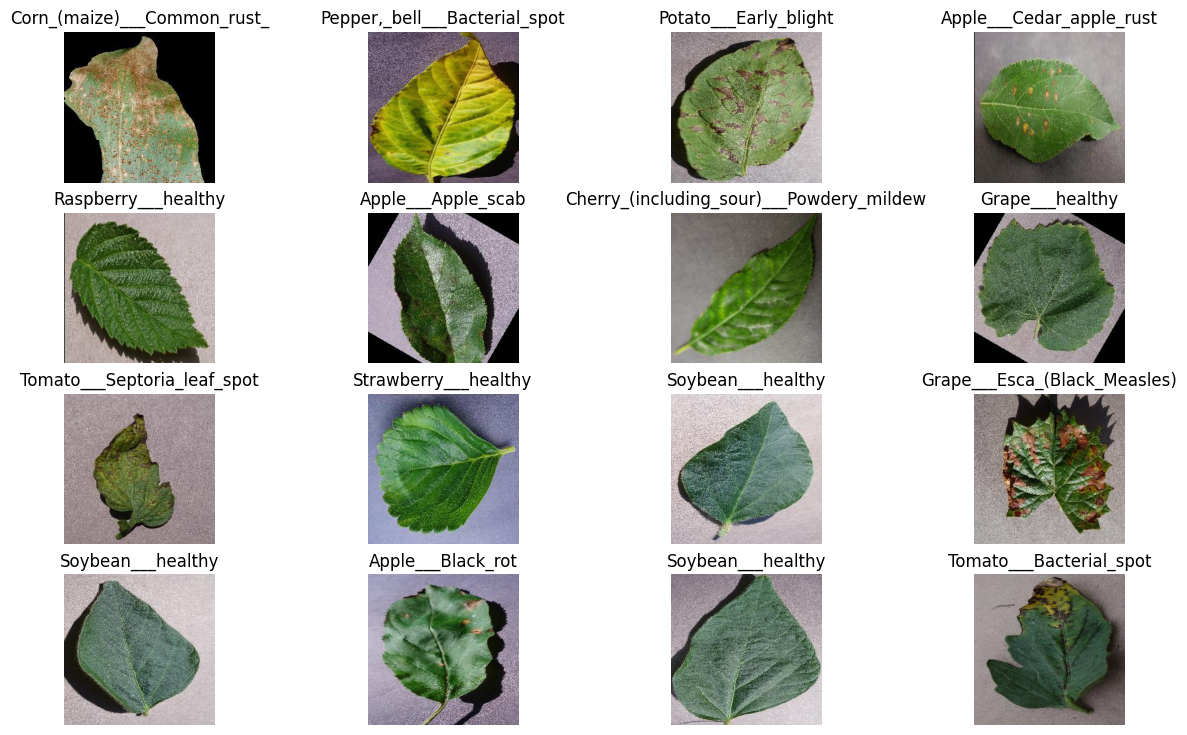

In [60]:
fig = plt.figure(figsize=(15, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train), size=[1]).item()
    img, label = train[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.title(class_names[label])
    plt.axis(False);

#Let's go to gpu

to increase the speed

In [21]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

Define **betch_size** hyperparameter to define how many samples ther must be in each batch consequently how many batches will be

In [28]:
batch_size = 32

train_dl = DataLoader(train, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid, batch_size=batch_size, shuffle=True)

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

print(f"Dataloaders: {train_dl, valid_dl}")
print(f"Length of train dataloader: {len(train_dl)} batches of {batch_size} samples")
print(f"Length of test dataloader: {len(valid_dl)} batches of {batch_size} samples")


Dataloaders: (<__main__.DeviceDataLoader object at 0x7fb30f17e230>, <__main__.DeviceDataLoader object at 0x7fb30f17c5e0>)
Length of train dataloader: 2197 batches of 32 samples
Length of test dataloader: 550 batches of 32 samples


# Let's go to build Nepsi


## Convo-Nepsi (Nepsi Convolutional Neural Network)

Define a NepsiBlock (a convolution block with BatchNormalization) to be called to build the network



In [29]:
def NepsiBlock(in_channels, out_channels, pool=False):
    nepsi_layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        nepsi_layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*nepsi_layers)

1. Define the convolutional network:

*   Layers
*   Forward step

2. Choose Hyperparameters:

*   Loss function
*   Optimizer

3. Save your trained model

   Load your trained model





In [ ]:
class Plant(nn.Module):
    def __init__(self, in_channels: int, diseases: int):
        super().__init__()

        self.conv1 = NepsiBlock(in_channels, 64)
        self.conv2 = NepsiBlock(64, 128, pool=True)
        self.res1 = nn.Sequential(NepsiBlock(128,128),NepsiBlock(128,128))

        self.conv3 = NepsiBlock(128,256, pool=True)
        self.conv4 = NepsiBlock(256, 512, pool=True)
        self.res2 = nn.Sequential(NepsiBlock(512,512), NepsiBlock(512,512))

        self.classifier = nn.Sequential((nn.MaxPool2d(4)),
                                        nn.Flatten(),
                                        nn.Linear(512, diseases))


    def forward(self,x):
      out = self.conv1(x)
      out = self.conv2(out)
      out = self.res1(out) + out
      out = self.conv3(out)
      out = self.conv4(out)
      out = self.res2(out) + out
      out = self.classifier(out)
      return out

    def save(self):
        torch.save(self.state_dict(), 'model_weights.pth')
        ## TODO:
        # salvare su un file txt un valore associato ai pesi

    def load(self):
        self.load_state_dict(torch.load('model_weights.pth'))
        # TODO:
        # verificare che il valore associato ai pesi loadati sia quello del file txt

torch.manual_seed(42)

convo_nepsi = to_device (Plant(in_channels=3,
                               diseases=len(class_names)), device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=convo_nepsi.parameters(),
                             lr=0.01)

convo_nepsi


**Train** pipeline:

0.   Optimizer zero grad
1.   Forward pass
2.   Calculate loss
3.   Back propagation
4.   Optimizer step

**Test** pipeline:

1. Forward pass
2. Calculate loss and accuracy



In [38]:
def train_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer, accuracy_fn):

    model.train()
    train_loss, train_acc = 0.0, 0.0

    for batch, (X, y) in enumerate(tqdm(data_loader)):
        # 0.
        optimizer.zero_grad()
        # 1.
        y_pred = model(X)
        # 2.
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels
        # 4.
        loss.backward()
        # 5.
        optimizer.step()

        if batch%100 == 0:
            print(f"Batch number: {batch}")
            print(f"Train loss: {train_loss / (batch+1):.3f}")
            print(f"Accuracy model: {train_acc / (batch+1):.3f}")
            model.save()


    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")



def test_step(data_loader: torch.utils.data.DataLoader, model: torch.nn.Module, loss_fn: torch.nn.Module, accuracy_fn):
    test_loss, test_acc = 0.0, 0.0
    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            # 1.
            test_pred = model(X)
            # 2.
            test_loss += loss_fn(test_pred, y).item()
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=-1) # Go from logits -> pred labels
            )


    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

Would you like to know  how long it took to train?

    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """

        """Calculates accuracy between truth labels and predictions.
    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.
    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """

In [39]:
def print_train_time(start: float, end: float):

    total_time = end - start
    print(f"Train time: {total_time:.3f} seconds")
    return total_time

**Accuracy_fn** allow us to know how much our model is accurate

In [42]:
def accuracy_fn(y_true, y_pred):

    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred))
    return acc

Is time for evaluaton !

"""Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """

In [44]:
def eval_model(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, accuracy_fn):

    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

# Let's go to train Nepsi

In [ ]:
torch.manual_seed(42)

train_time_start = timer()

epochs = 3
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dl,
        model=convo_nepsi,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=valid_dl,
        model=convo_nepsi,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end= timer()
total_train_time_model_1 = print_train_time(start=train_time_start, end=train_time_end)

Epoch: 0
---------


  0%|          | 0/2197 [00:00<?, ?it/s]

Batch number: 0
Train loss: 1.933
Accuracy model: 0.406


  5%|▍         | 100/2197 [00:50<17:02,  2.05it/s]

Batch number: 100
Train loss: 2.107
Accuracy model: 0.389


  9%|▉         | 200/2197 [01:41<15:18,  2.17it/s]

Batch number: 200
Train loss: 1.874
Accuracy model: 0.446


 14%|█▎        | 300/2197 [02:35<14:36,  2.16it/s]

Batch number: 300
Train loss: 1.645
Accuracy model: 0.512


 18%|█▊        | 400/2197 [03:30<14:11,  2.11it/s]

Batch number: 400
Train loss: 1.482
Accuracy model: 0.558


 23%|██▎       | 500/2197 [04:23<13:59,  2.02it/s]

Batch number: 500
Train loss: 1.329
Accuracy model: 0.601


 27%|██▋       | 601/2197 [05:18<18:41,  1.42it/s]

Batch number: 600
Train loss: 1.209
Accuracy model: 0.636


 32%|███▏      | 700/2197 [06:09<14:09,  1.76it/s]

Batch number: 700
Train loss: 1.109
Accuracy model: 0.665


 36%|███▋      | 800/2197 [07:01<11:20,  2.05it/s]

Batch number: 800
Train loss: 1.034
Accuracy model: 0.686


 41%|████      | 900/2197 [07:53<10:32,  2.05it/s]

Batch number: 900
Train loss: 0.967
Accuracy model: 0.706


 46%|████▌     | 1000/2197 [08:45<09:42,  2.05it/s]

Batch number: 1000
Train loss: 0.913
Accuracy model: 0.722


 50%|█████     | 1100/2197 [09:36<11:00,  1.66it/s]

Batch number: 1100
Train loss: 0.864
Accuracy model: 0.736


 55%|█████▍    | 1200/2197 [10:28<10:39,  1.56it/s]

Batch number: 1200
Train loss: 0.821
Accuracy model: 0.748


 59%|█████▉    | 1300/2197 [11:19<09:18,  1.61it/s]

Batch number: 1300
Train loss: 0.785
Accuracy model: 0.759


 64%|██████▎   | 1400/2197 [12:10<07:44,  1.72it/s]

Batch number: 1400
Train loss: 0.753
Accuracy model: 0.768


 68%|██████▊   | 1500/2197 [13:00<05:22,  2.16it/s]

Batch number: 1500
Train loss: 0.723
Accuracy model: 0.777


 73%|███████▎  | 1600/2197 [13:51<04:35,  2.17it/s]

Batch number: 1600
Train loss: 0.693
Accuracy model: 0.786


 77%|███████▋  | 1700/2197 [14:44<04:10,  1.98it/s]

Batch number: 1700
Train loss: 0.670
Accuracy model: 0.793


 82%|████████▏ | 1800/2197 [15:37<03:03,  2.16it/s]

Batch number: 1800
Train loss: 0.647
Accuracy model: 0.800


 86%|████████▋ | 1900/2197 [16:29<02:17,  2.17it/s]

Batch number: 1900
Train loss: 0.627
Accuracy model: 0.806


 91%|█████████ | 2000/2197 [17:20<01:30,  2.16it/s]

Batch number: 2000
Train loss: 0.608
Accuracy model: 0.812


 96%|█████████▌| 2100/2197 [18:10<00:46,  2.11it/s]

Batch number: 2100
Train loss: 0.589
Accuracy model: 0.817


100%|██████████| 2197/2197 [18:59<00:00,  1.93it/s]


Train loss: 0.57310 | Train accuracy: 0.82%
Test loss: 0.43015 | Test accuracy: 0.86%

Epoch: 1
---------


  0%|          | 0/2197 [00:00<?, ?it/s]

Batch number: 0
Train loss: 0.035
Accuracy model: 1.000


  5%|▍         | 100/2197 [00:50<16:06,  2.17it/s]

Batch number: 100
Train loss: 0.185
Accuracy model: 0.941


  9%|▉         | 200/2197 [01:42<15:23,  2.16it/s]

Batch number: 200
Train loss: 0.190
Accuracy model: 0.941


 14%|█▎        | 300/2197 [02:34<14:38,  2.16it/s]

Batch number: 300
Train loss: 0.204
Accuracy model: 0.936


 18%|█▊        | 400/2197 [03:26<13:50,  2.16it/s]

Batch number: 400
Train loss: 0.210
Accuracy model: 0.934


 23%|██▎       | 500/2197 [04:18<13:06,  2.16it/s]

Batch number: 500
Train loss: 0.210
Accuracy model: 0.933


 27%|██▋       | 600/2197 [05:10<12:19,  2.16it/s]

Batch number: 600
Train loss: 0.202
Accuracy model: 0.936


 32%|███▏      | 700/2197 [06:00<11:33,  2.16it/s]

Batch number: 700
Train loss: 0.210
Accuracy model: 0.934


 36%|███▋      | 800/2197 [06:50<11:01,  2.11it/s]

Batch number: 800
Train loss: 0.209
Accuracy model: 0.934


 41%|████      | 900/2197 [07:41<14:41,  1.47it/s]

Batch number: 900
Train loss: 0.204
Accuracy model: 0.936


 46%|████▌     | 1000/2197 [08:31<09:12,  2.17it/s]

Batch number: 1000
Train loss: 0.201
Accuracy model: 0.936


 50%|█████     | 1100/2197 [09:23<08:26,  2.17it/s]

Batch number: 1100
Train loss: 0.203
Accuracy model: 0.936


 55%|█████▍    | 1200/2197 [10:13<07:39,  2.17it/s]

Batch number: 1200
Train loss: 0.204
Accuracy model: 0.935


 59%|█████▉    | 1300/2197 [11:05<06:54,  2.16it/s]

Batch number: 1300
Train loss: 0.204
Accuracy model: 0.935


 64%|██████▎   | 1400/2197 [11:55<06:10,  2.15it/s]

Batch number: 1400
Train loss: 0.201
Accuracy model: 0.936


 68%|██████▊   | 1500/2197 [12:48<05:24,  2.15it/s]

Batch number: 1500
Train loss: 0.202
Accuracy model: 0.936


 73%|███████▎  | 1600/2197 [13:40<04:35,  2.16it/s]

Batch number: 1600
Train loss: 0.200
Accuracy model: 0.936


 77%|███████▋  | 1700/2197 [14:31<03:51,  2.15it/s]

Batch number: 1700
Train loss: 0.199
Accuracy model: 0.936


 82%|████████▏ | 1800/2197 [15:21<03:07,  2.12it/s]

Batch number: 1800
Train loss: 0.197
Accuracy model: 0.938


 86%|████████▋ | 1900/2197 [16:11<02:22,  2.09it/s]

Batch number: 1900
Train loss: 0.194
Accuracy model: 0.938


 91%|█████████ | 2000/2197 [17:02<02:06,  1.56it/s]

Batch number: 2000
Train loss: 0.193
Accuracy model: 0.938


 96%|█████████▌| 2100/2197 [17:54<00:52,  1.85it/s]

Batch number: 2100
Train loss: 0.192
Accuracy model: 0.939


100%|██████████| 2197/2197 [18:42<00:00,  1.96it/s]


Train loss: 0.19016 | Train accuracy: 0.94%
Test loss: 0.30856 | Test accuracy: 0.91%

Epoch: 2
---------


  0%|          | 0/2197 [00:00<?, ?it/s]

Batch number: 0
Train loss: 0.108
Accuracy model: 0.969


  5%|▍         | 100/2197 [00:49<18:26,  1.89it/s]

Batch number: 100
Train loss: 0.131
Accuracy model: 0.956


  9%|▉         | 200/2197 [01:40<24:38,  1.35it/s]

Batch number: 200
Train loss: 0.138
Accuracy model: 0.953


 14%|█▎        | 300/2197 [02:29<14:36,  2.16it/s]

Batch number: 300
Train loss: 0.133
Accuracy model: 0.955


 18%|█▊        | 400/2197 [03:18<13:52,  2.16it/s]

Batch number: 400
Train loss: 0.147
Accuracy model: 0.951


 23%|██▎       | 500/2197 [04:07<14:09,  2.00it/s]

Batch number: 500
Train loss: 0.152
Accuracy model: 0.950


 27%|██▋       | 600/2197 [04:58<17:45,  1.50it/s]

Batch number: 600
Train loss: 0.149
Accuracy model: 0.951


 32%|███▏      | 700/2197 [05:47<11:31,  2.16it/s]

Batch number: 700
Train loss: 0.144
Accuracy model: 0.953


 36%|███▋      | 800/2197 [06:37<10:42,  2.18it/s]

Batch number: 800
Train loss: 0.145
Accuracy model: 0.953


 41%|████      | 900/2197 [07:27<10:00,  2.16it/s]

Batch number: 900
Train loss: 0.145
Accuracy model: 0.953


 46%|████▌     | 1000/2197 [08:16<09:47,  2.04it/s]

Batch number: 1000
Train loss: 0.146
Accuracy model: 0.953


 50%|█████     | 1100/2197 [09:07<11:08,  1.64it/s]

Batch number: 1100
Train loss: 0.146
Accuracy model: 0.953


 55%|█████▍    | 1200/2197 [09:56<07:39,  2.17it/s]

Batch number: 1200
Train loss: 0.146
Accuracy model: 0.953


 59%|█████▉    | 1300/2197 [10:44<06:59,  2.14it/s]

Batch number: 1300
Train loss: 0.145
Accuracy model: 0.954


 64%|██████▎   | 1400/2197 [11:35<06:31,  2.03it/s]

Batch number: 1400
Train loss: 0.142
Accuracy model: 0.955


 68%|██████▊   | 1500/2197 [12:25<08:59,  1.29it/s]

Batch number: 1500
Train loss: 0.142
Accuracy model: 0.955


 73%|███████▎  | 1600/2197 [13:13<04:34,  2.18it/s]

Batch number: 1600
Train loss: 0.142
Accuracy model: 0.955


 77%|███████▋  | 1700/2197 [14:04<03:49,  2.16it/s]

Batch number: 1700
Train loss: 0.142
Accuracy model: 0.955


 82%|████████▏ | 1800/2197 [14:55<03:04,  2.15it/s]

Batch number: 1800
Train loss: 0.141
Accuracy model: 0.955


 86%|████████▋ | 1900/2197 [15:47<02:18,  2.14it/s]

Batch number: 1900
Train loss: 0.141
Accuracy model: 0.955


 91%|█████████ | 2000/2197 [16:36<01:39,  1.99it/s]

Batch number: 2000
Train loss: 0.140
Accuracy model: 0.955


 96%|█████████▌| 2100/2197 [17:28<01:16,  1.26it/s]

Batch number: 2100
Train loss: 0.140
Accuracy model: 0.956


100%|██████████| 2197/2197 [18:18<00:00,  2.00it/s]


Train loss: 0.13950 | Train accuracy: 0.96%


#Test our trained model

In log.txt you will find taining details

0. Load parameters (model_weights.pth)
1. Copy and past directory where your images are stored
2. Yor turn to go to tensor

In [ ]:
#1
YourDir =
#2
YourImage = ImageFolder(YourDir, transform=transform)
YourImage_dl = DeviceDataLoader(YourImage, device)

Test

In [64]:
test_step(data_loader=valid_dl, model=convo_nepsi, loss_fn=loss_fn, accuracy_fn=accuracy_fn)

Test loss: 0.14461 | Test accuracy: 0.96%

